In [1]:
import pandas as pd
import numpy as np
import pickle as pkl
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
wv  = torch.load("./dataset/word2vec_emb_tensor.pkl")

In [3]:
cnn = torch.load("./dataset/cnn_emb_tensor.pkl")

In [4]:
X = torch.cat((wv,cnn),dim=1)

In [5]:
X.shape

torch.Size([5000, 1100])

In [6]:
df = pd.read_csv("./dataset/books_with_genres.csv")

In [7]:
y = df["average_rating"]

In [8]:
y = y.to_numpy()
y = torch.from_numpy(y)

Train test split

In [9]:
X_train = X[[i for i in range(4000)]]
X_test = X[[i for i in range(4000,5000)]]
y_train = y[[i for i in range(4000)]]
y_test = y[[i for i in range(4000, 5000)]]

In [10]:
y_train

tensor([4.0300, 4.2600, 4.4300,  ..., 4.1200, 3.9600, 3.8300],
       dtype=torch.float64)

In [11]:
device = torch.device("cuda")

In [12]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        #out = self.relu2(out)
        #out = self.fc3(out)
        return out

In [13]:
net = MLP(1100,1,512)

In [14]:
net=net.to(device)

In [15]:
import torch.optim as optim
from random import randint

bs = 20

for epoch in range(50):

    criterion = nn.MSELoss()
    optimizer=torch.optim.SGD(net.parameters() , lr=5e-4 )

    for iter in range(1,1000):

        # create a minibatch
        indices=torch.LongTensor(bs).random_(0,4000)
        minibatch_data =  X_train[indices].to(device)
        minibatch_label = y_train[indices].float().to(device)

        #reshape them to fit the network
        inputs=minibatch_data.view(bs,1100)
        # feed the input to the net  
        inputs.requires_grad_()
        prob=net(inputs)


        # update the weights (all the magic happens here -- we will discuss it later)
        loss = criterion(prob, minibatch_label)    
        optimizer.zero_grad()       
        loss.backward()
        optimizer.step()

C:\Users\AISWARYA\Miniconda3\envs\seat\lib\site-packages\torch\nn\modules\loss.py:528: UserWarning: Using a target size (torch.Size([20])) that is different to the input size (torch.Size([20, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


In [16]:
def get_error( scores , labels ):

    predicted_labels = scores
    indicator = criterion(scores,labels)
    
    return indicator    

In [17]:

running_error=0
num_batches=0


for i in range(0,1000,bs):

    # extract the minibatch
    minibatch_data =  X_test[i:i+bs].to(device)
    minibatch_label= y_test[i:i+bs].float().to(device)

    # reshape the minibatch
    inputs = minibatch_data.view(bs,1100)

    # feed it to the network
    scores=net( inputs ) 

    # compute the error made on this batch
    error = get_error( scores , minibatch_label)
    
    # add it to the running error
    running_error += error.item()

    num_batches+=1


# compute error rate on the full test set
total_error = running_error/num_batches

print( 'error rate on test set =', total_error*100 ,'percent')

error rate on test set = 20.422578305006027 percent


In [18]:
pred = []
for i in range (0,1000):
    pred.append(net(X_test[i].to(device)).item())
pred = torch.tensor(pred)

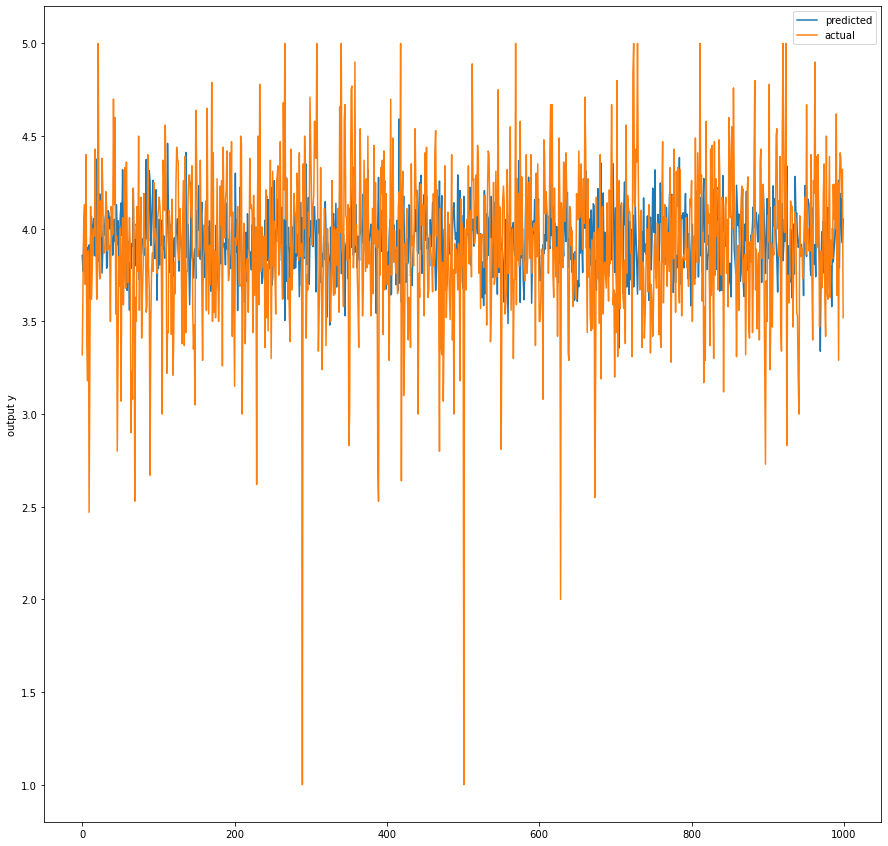

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,15))
plt.plot(pred, label='predicted')
plt.plot(y_test, label='actual')
plt.ylabel('output y')
plt.legend()
plt.show()

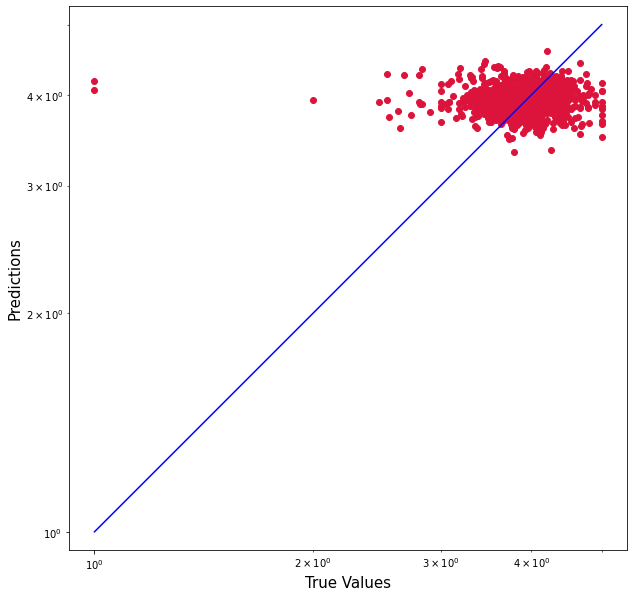

In [20]:
plt.figure(figsize=(10,10))
plt.scatter(y_test, pred, c='crimson')
plt.yscale('log')
plt.xscale('log')

p1 = max(max(pred), max(y_test))
p2 = min(min(pred), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('True Values', fontsize=15)
plt.ylabel('Predictions', fontsize=15)
plt.axis('equal')
plt.show()

In [21]:
book_id = df["book_id"]

In [22]:
book_id = book_id.to_numpy()
book_id = torch.from_numpy(book_id)

In [23]:
train_book_id = book_id[[i for i in range(4000)]]
test_book_id = book_id[[i for i in range(4000,5000)]]

In [24]:
torch.save(train_book_id, "./dataset/train_book_id.pkl")
torch.save(test_book_id, "./dataset/test_book_id.pkl")